In [1]:
#!pip install pandas openpyxl geopandas matplotlib

import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

## DATACENTER WITH ID "3668" HAS INVERTED LONGITUDE. IS 122, SHOULD BE -122

## Remember to find missing temperatures for hawaii, alaska and district of columbia

In [2]:
data = '../in/datacentermap.csv'

#dc_df = datacenter_dataframe
dc_df = pd.read_csv(data)

# Remove inplace=True
dc_df.drop(['postal', 'link_profile'], axis=1, inplace=True)

mainCountry = 'USA'

mask = dc_df['country'] == mainCountry

dc_df = dc_df[mask]

# Create a GeoDataFrame
dc_gdf = gpd.GeoDataFrame(dc_df, geometry=gpd.points_from_xy(dc_df.longitude, dc_df.latitude))

# Define or identify the coordinate reference system (CRS)
# For the United States, you can use EPSG:4326 (WGS 84) which is commonly used for latitude and longitude coordinates
dc_gdf.crs = "EPSG:4326"

# Loading custom us state shapefile
states_map = gpd.read_file('../in/States_shapefile-shp/States_shapefile.shp')

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

def plot_us_states(gdf, data_column=None, plot_points=None, title='INSERT TITLE', colormap='RdYlGn', point_color='black', point_size=3, point_opacity=1, label_states=False, colorbar_title=None, log_scale=False):
    fig = plt.figure(figsize=(20, 13))
    fig.suptitle(title, fontsize=24)
    
    # Exclude Hawaii and Alaska when making the initial mainland/contiguous plot
    mainland_us = gdf[~gdf['State_Name'].isin(['HAWAII', 'ALASKA'])]
    # Make new geodataframes for each of the excluded states
    alaska = gdf[gdf['State_Name'] == 'ALASKA']
    hawaii = gdf[gdf['State_Name'] == 'HAWAII']

# Normalize the color map based on the entire dataset
    if data_column:
        if log_scale:
            #if user is choosing to plot on a logarithmic scale, normalize the data values logarithmically 
            norm = mcolors.LogNorm(vmin=gdf[data_column].replace(0, np.nan).min(), vmax=gdf[data_column].max())
        else:
            # if user hasnt specified logarithmi scale, normalize the values as normal
            norm = mcolors.Normalize(vmin=gdf[data_column].min(), vmax=gdf[data_column].max())

    # Create a new axis for mainland US
    ax_mainland = fig.add_axes([0, 0.05, 1, 1])  # [x, y, width, height]
    if data_column:
        # Plot mainland US with data column
        mainland_us.plot(column=data_column, cmap=colormap, norm=norm, linewidth=0.8, ax=ax_mainland, edgecolor='0.5', legend=False, missing_kwds={'color': 'lightgrey'})
    else:
        # Plot mainland US without data column (all states in gray)
        mainland_us.plot(color='lightgrey', linewidth=0.8, ax=ax_mainland, edgecolor='0.5')

    # Add Alaska Axis (x, y, width, height)
    akax = fig.add_axes([-0.05, 0.1, 0.3, 0.3])
    if data_column:
        # Plot Alaska with data column
        alaska.plot(column=data_column, cmap=colormap, norm=norm, linewidth=0.8, ax=akax, edgecolor='0.5', missing_kwds={'color': 'lightgrey'})
    else:
        # Plot Alaska without data column (all states in gray)
        alaska.plot(color='lightgrey', linewidth=0.8, ax=akax, edgecolor='0.5')
    akax.set_title('Alaska', fontsize=20)
    
    # Add Hawaii Axis (x, y, width, height)
    hiax = fig.add_axes([0.225, 0.15, 0.15, 0.15])
    if data_column:
        # Plot Hawaii with data column
        hawaii.plot(column=data_column, cmap=colormap, norm=norm, linewidth=0.8, ax=hiax, edgecolor='0.5', missing_kwds={'color': 'lightgrey'})
    else:
        # Plot Hawaii without data column (all states in gray)
        hawaii.plot(color='lightgrey', linewidth=0.8, ax=hiax, edgecolor='0.5')
    hiax.set_title('Hawaii', fontsize=20)

    # Hide all axes borders and labels
    ax_mainland.set_axis_off()
    akax.set_axis_off()
    hiax.set_axis_off()

    # If plotting datacenter locations, make a new geodataframe for datacenter point locations for the mainland, Alaska and Hawaii
    if plot_points is not None:
        # Exclude Hawaii and Alaska when making the initial mainland/contiguous plot
        mainland_us_dc = plot_points[~plot_points['state'].isin(['Hawaii', 'Alaska'])]
        # We only have to make a datacenter gdf for Hawaii, since Alaska doesn't have any datacenters of its own!
        hawaii_dc = plot_points[plot_points['state'] == 'Hawaii']

        # Plot the data points on the mainland map
        mainland_us_dc.plot(ax=ax_mainland, color=point_color, markersize=point_size, alpha=point_opacity)
        
        # Plot the data points on the Hawaii map
        hawaii_dc.plot(ax=hiax, color=point_color, markersize=point_size, alpha=point_opacity)

    if label_states and data_column:
        label_size = 15
        for idx, row in mainland_us.iterrows():
            #f"{row[data_column]:.2f}".rstrip('0').rstrip('.') rounds to 2 decimal places, and if the float value is an integer value, e.g. 23.00, we strip the 0's
            ax_mainland.text(row.geometry.centroid.x, row.geometry.centroid.y, 
                             s=f"{row[data_column]:.2f}".rstrip('0').rstrip('.'), horizontalalignment='center', fontsize=label_size)

        if not alaska.empty:
            row = alaska.iloc[0]
            akax.text(row.geometry.centroid.x, row.geometry.centroid.y, 
                      s=f"{row[data_column]:.2f}".rstrip('0').rstrip('.'), horizontalalignment='center', fontsize=label_size)
        
        if not hawaii.empty:
            row = hawaii.iloc[0]
            hiax.text(row.geometry.centroid.x, row.geometry.centroid.y, 
                      s=f"{row[data_column]:.2f}".rstrip('0').rstrip('.'), horizontalalignment='center', fontsize=label_size)

    if data_column:
        # Create an axis for the colorbar
        cax = fig.add_axes([0.05, 0.07, 0.9, 0.02])  # [x, y, width, height]
        # Create a ScalarMappable for the colorbar based on the colormap and normalization of the data values.
        sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
        sm._A = []  # This is needed for ScalarMappable
        # Give the colorbar a title named after the data column we are plotting
        if colorbar_title == None:
           colorbar_title = data_column
        cax.set_title(colorbar_title, fontsize=20)
        cax.tick_params(labelsize=20)
        fig.colorbar(sm, cax=cax, orientation='horizontal')

    plt.show()


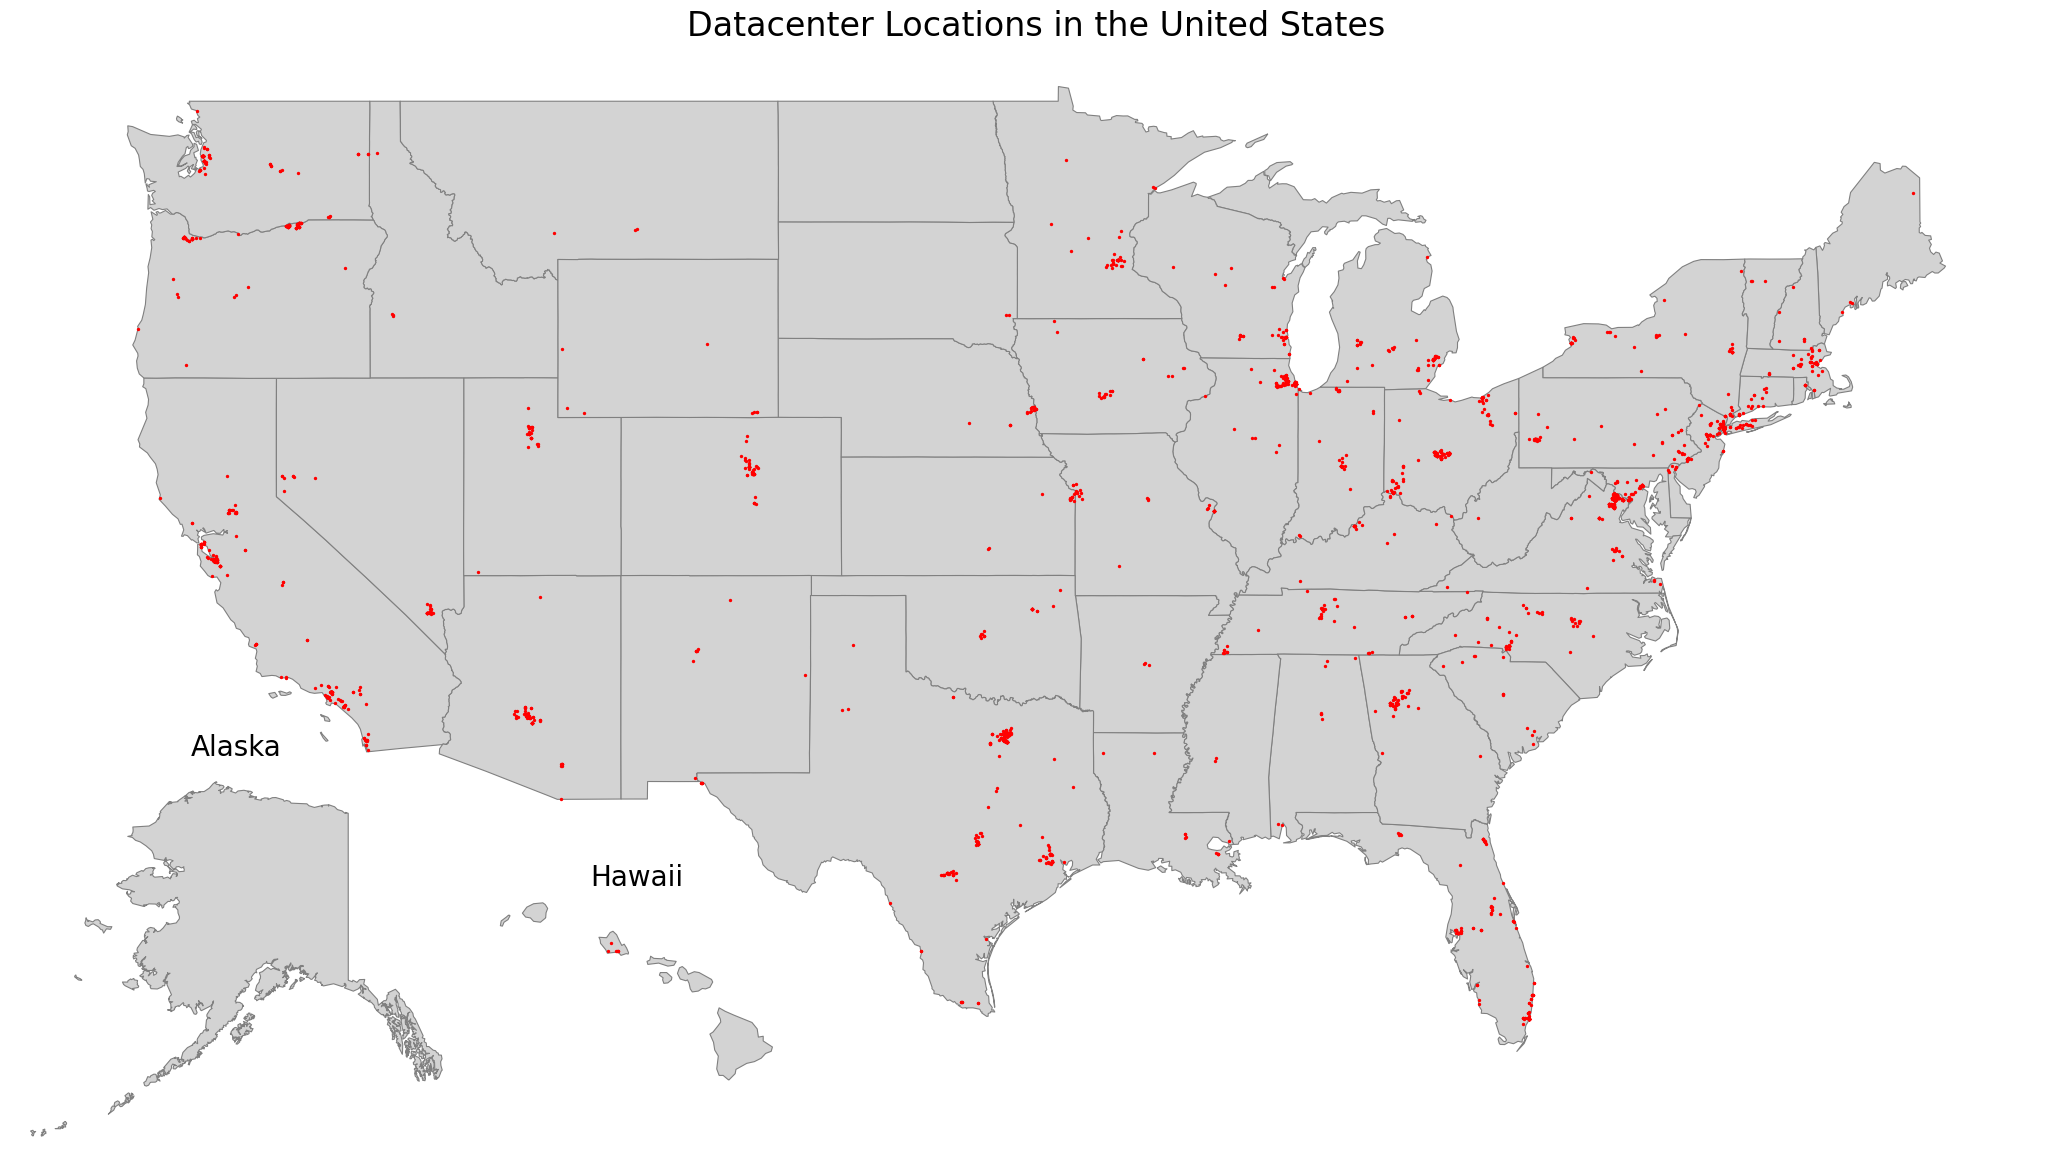

In [4]:
plot_us_states(states_map, 
               title='Datacenter Locations in the United States', 
               plot_points=dc_gdf, 
               point_color='red',
               point_size=2)

In [5]:
def uppercase_df(input_df):
    return input_df.map(lambda x: x.upper() if isinstance(x, str) else x)

def remove_trailing_space_df(input_df):
    return input_df.map(lambda x: x.strip() if isinstance(x, str) else x)

In [6]:
state_counts = dc_df['state'].value_counts().reset_index()
# Convert all string values in the dataframe to uppercase since the shapefile uses uppercase state names
state_counts = uppercase_df(state_counts)
state_counts.columns = ['State_Name', 'Datacenter_Count']
state_counts.head()

,State_Name,Datacenter_Count
0,VIRGINIA,311
1,CALIFORNIA,259
2,TEXAS,241
3,OHIO,150
4,NEW YORK,128


In [7]:
# Merge the state counts with the state shapefile map based on state names
merged_data = states_map.merge(state_counts, how='left', on='State_Name')

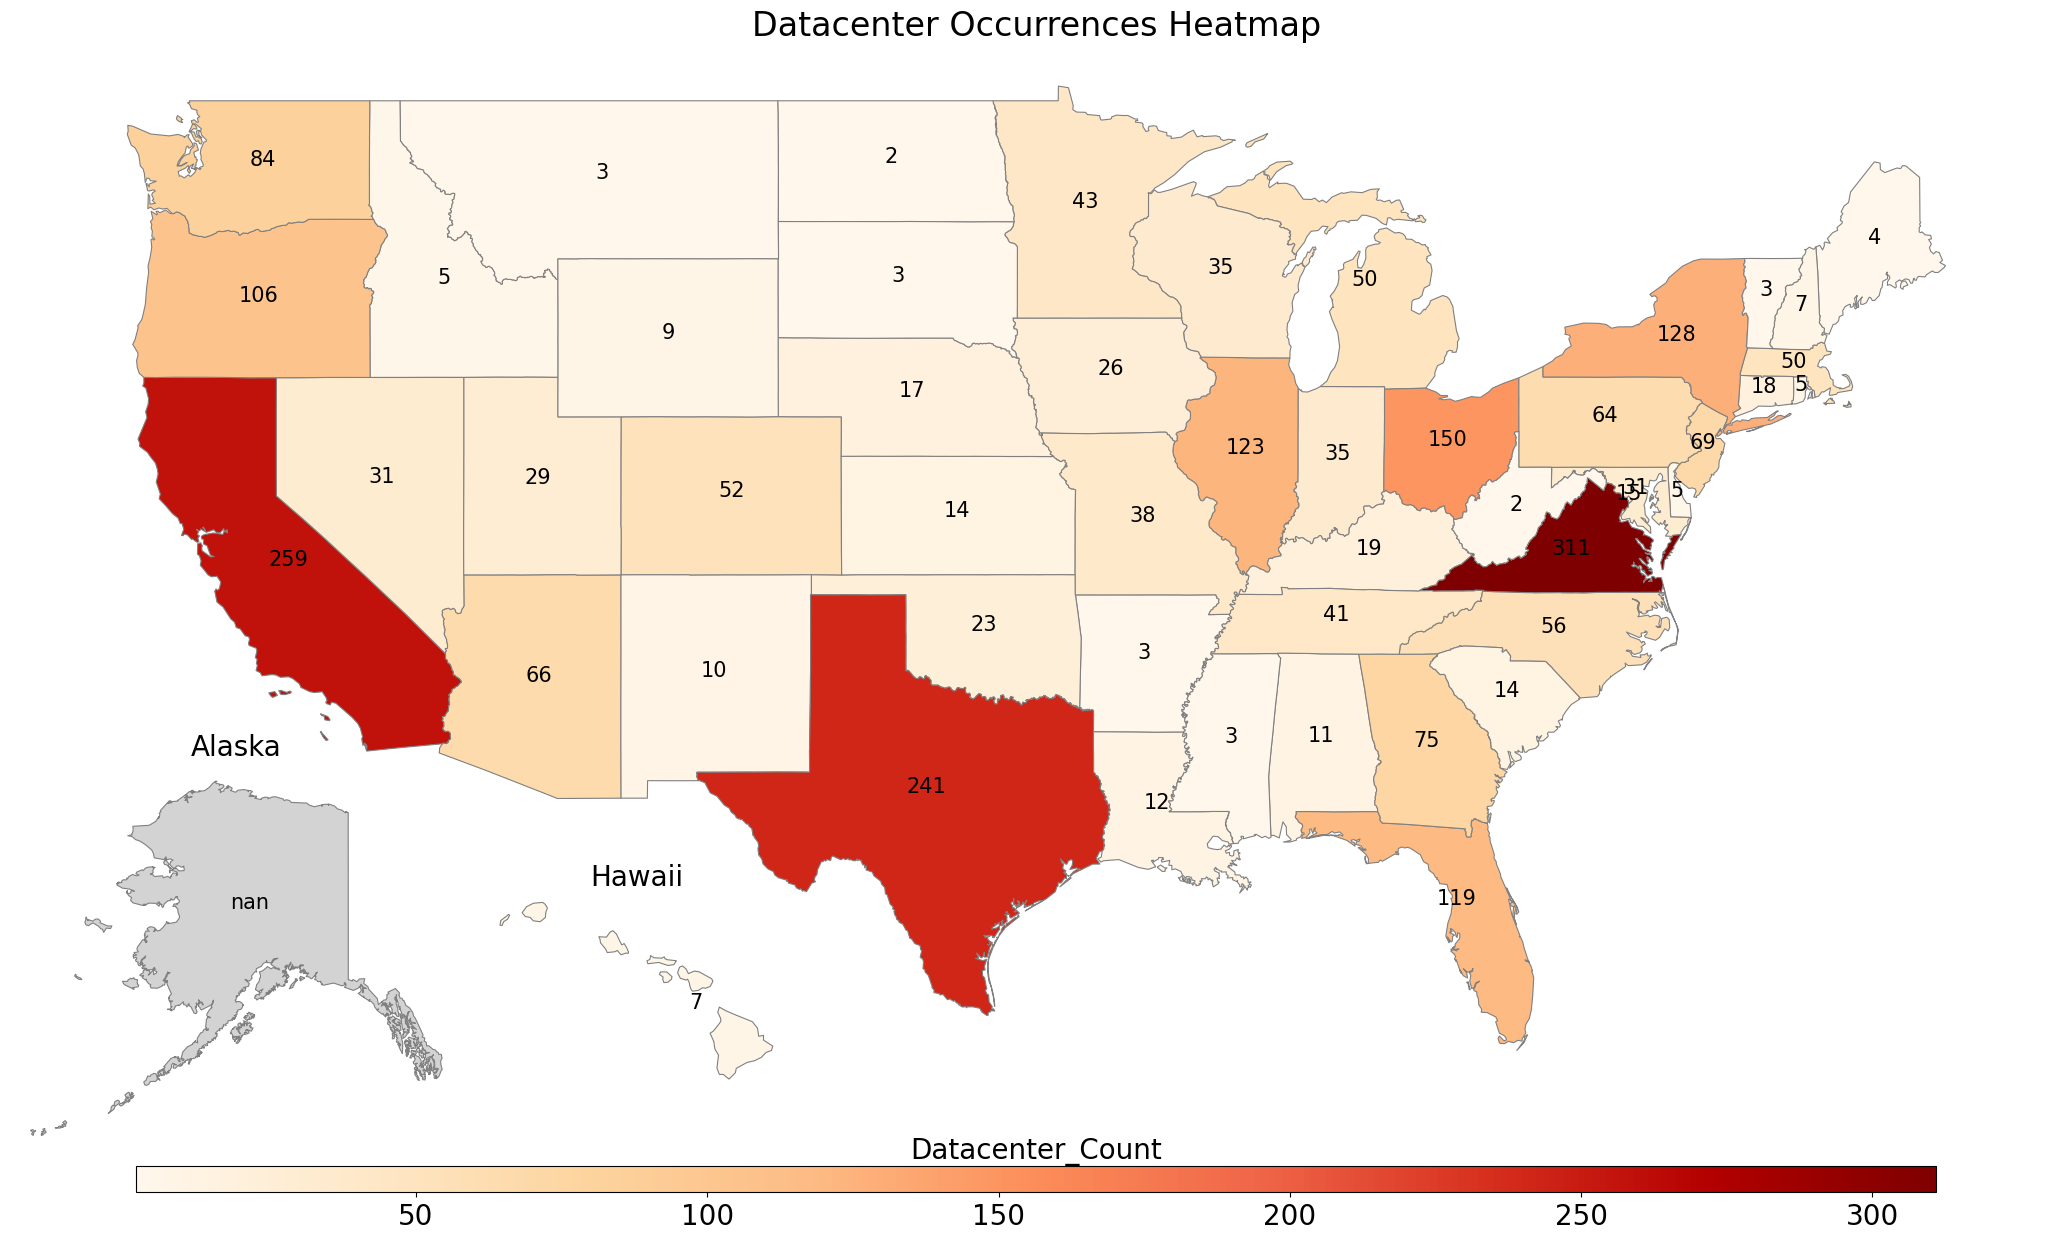

In [8]:
data_column = 'Datacenter_Count'

title = f'Datacenter Occurrences Heatmap'

plot_us_states(merged_data, data_column, title=title, colormap='OrRd', label_states=True)

In [9]:
power_df = pd.read_excel('../in/avgprice_annual.xlsx', skiprows=1)

#only keeping power prices from 2020
power_df = power_df[power_df['Year'] == 2020]

#only keeping "total electric industry" as the industry sector as its the only one that has all 51 states.
power_df = power_df[power_df['Industry Sector Category'] == 'Total Electric Industry']


In [10]:
#Add the power prices to the merged data 
merged_data = merged_data.merge(power_df, how='left', left_on='State_Code', right_on='State')

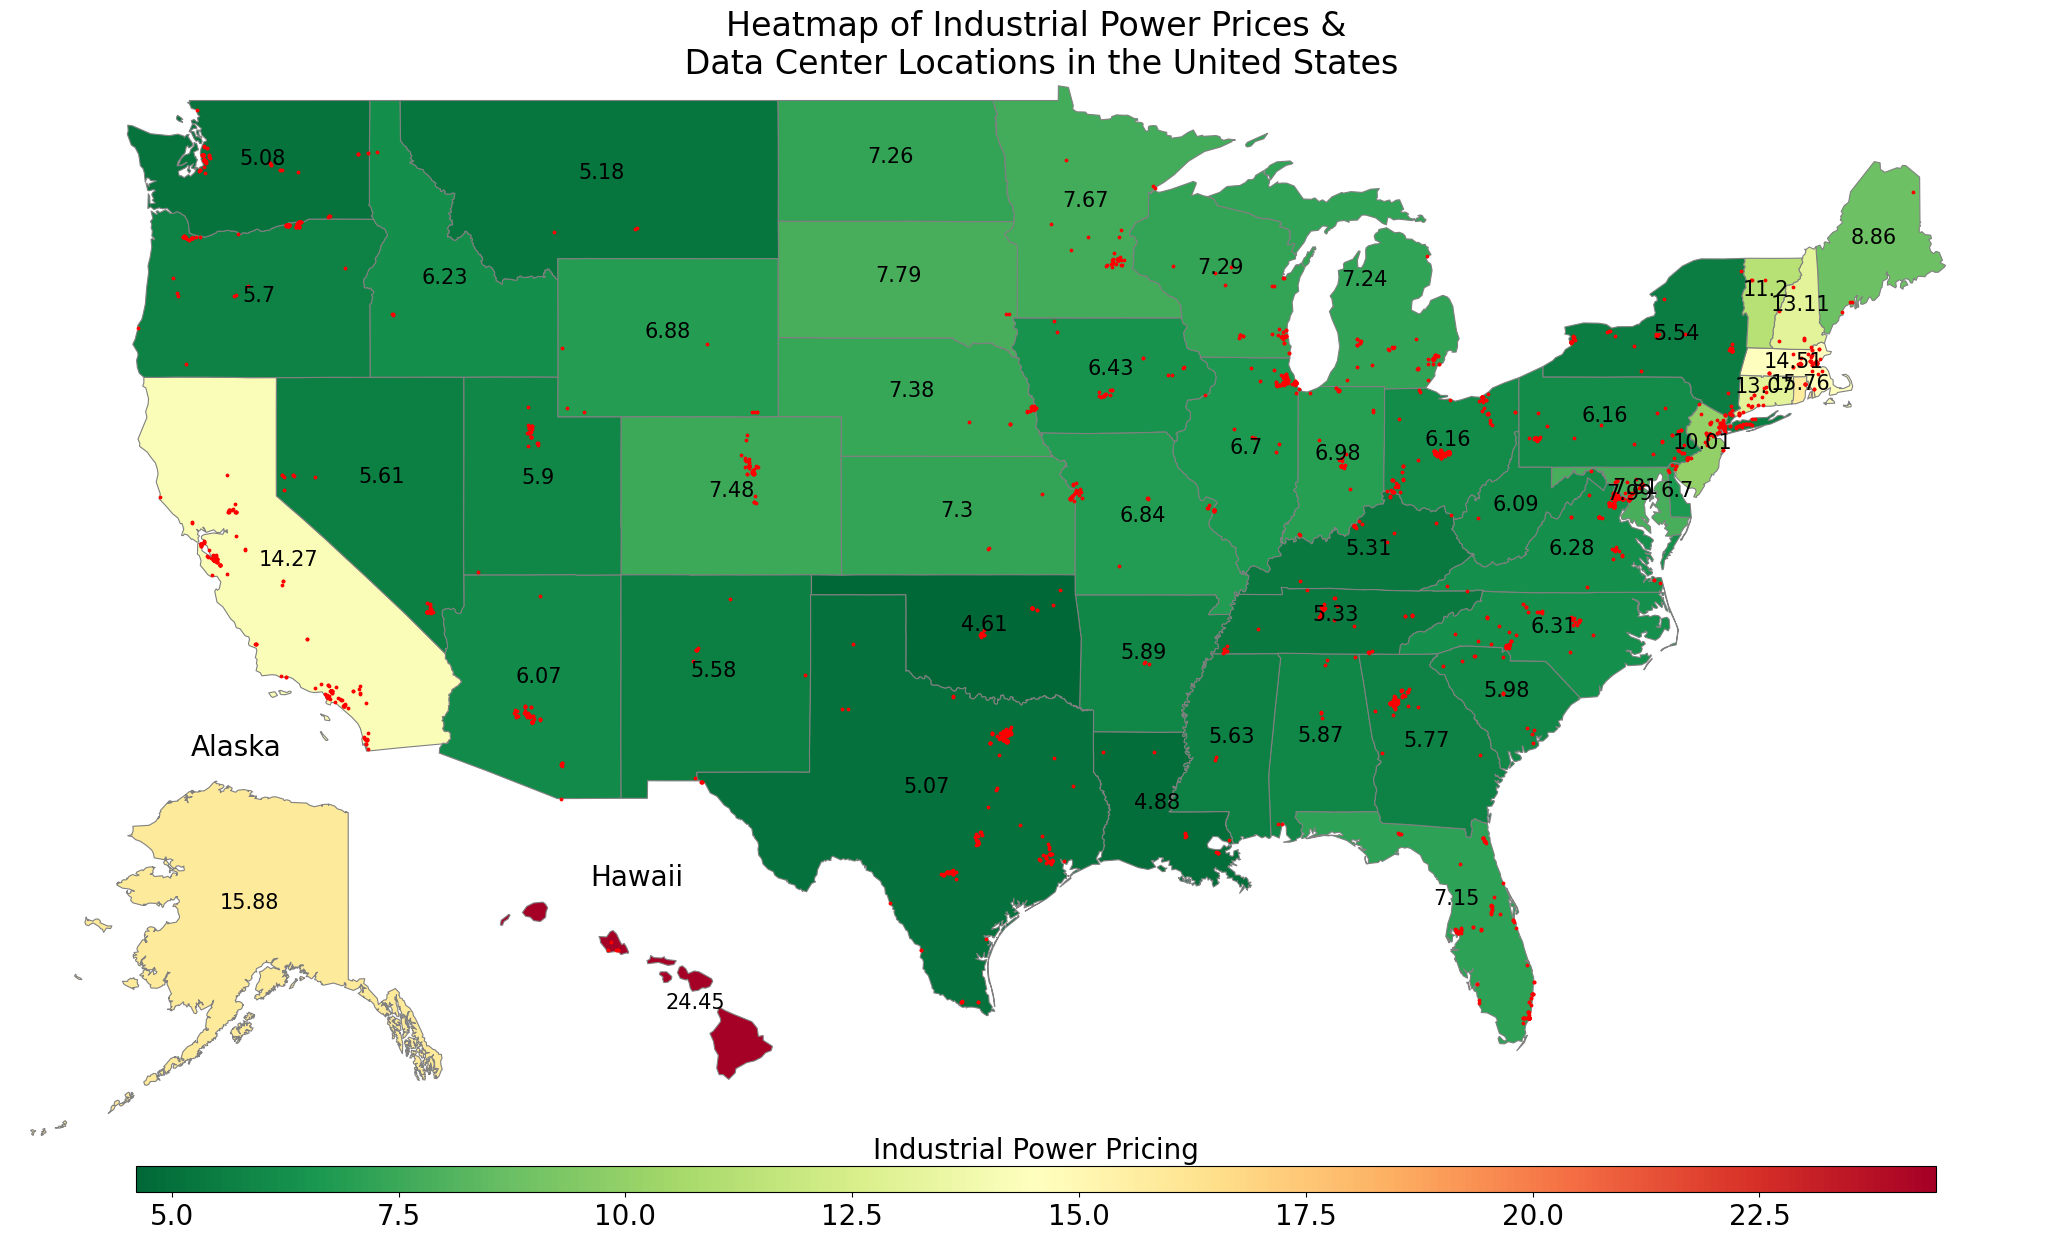

In [11]:
power_sector = 'Industrial'

title = f'Heatmap of {power_sector} Power Prices &\n Data Center Locations in the United States'

plot_us_states(merged_data, power_sector, 
               title=title, 
               colorbar_title='Industrial Power Pricing',
               label_states=True,
               plot_points=dc_gdf, 
               point_color='red',
               colormap='RdYlGn_r')

# Internet speed

In [12]:
internet_df = pd.read_csv('../in/internet_speed_by_region.csv')

internet_df.rename(columns={'Region': 'State_Name'}, inplace=True)

internet_df = uppercase_df(internet_df)

internet_df.head()

,State_Name,Internet Speed
0,ALABAMA,84.26
1,ALASKA,35.51
2,ARIZONA,81.22
3,ARKANSAS,63.18
4,CALIFORNIA,94.45


In [13]:
merged_data = merged_data.merge(internet_df, how='left', on='State_Name')

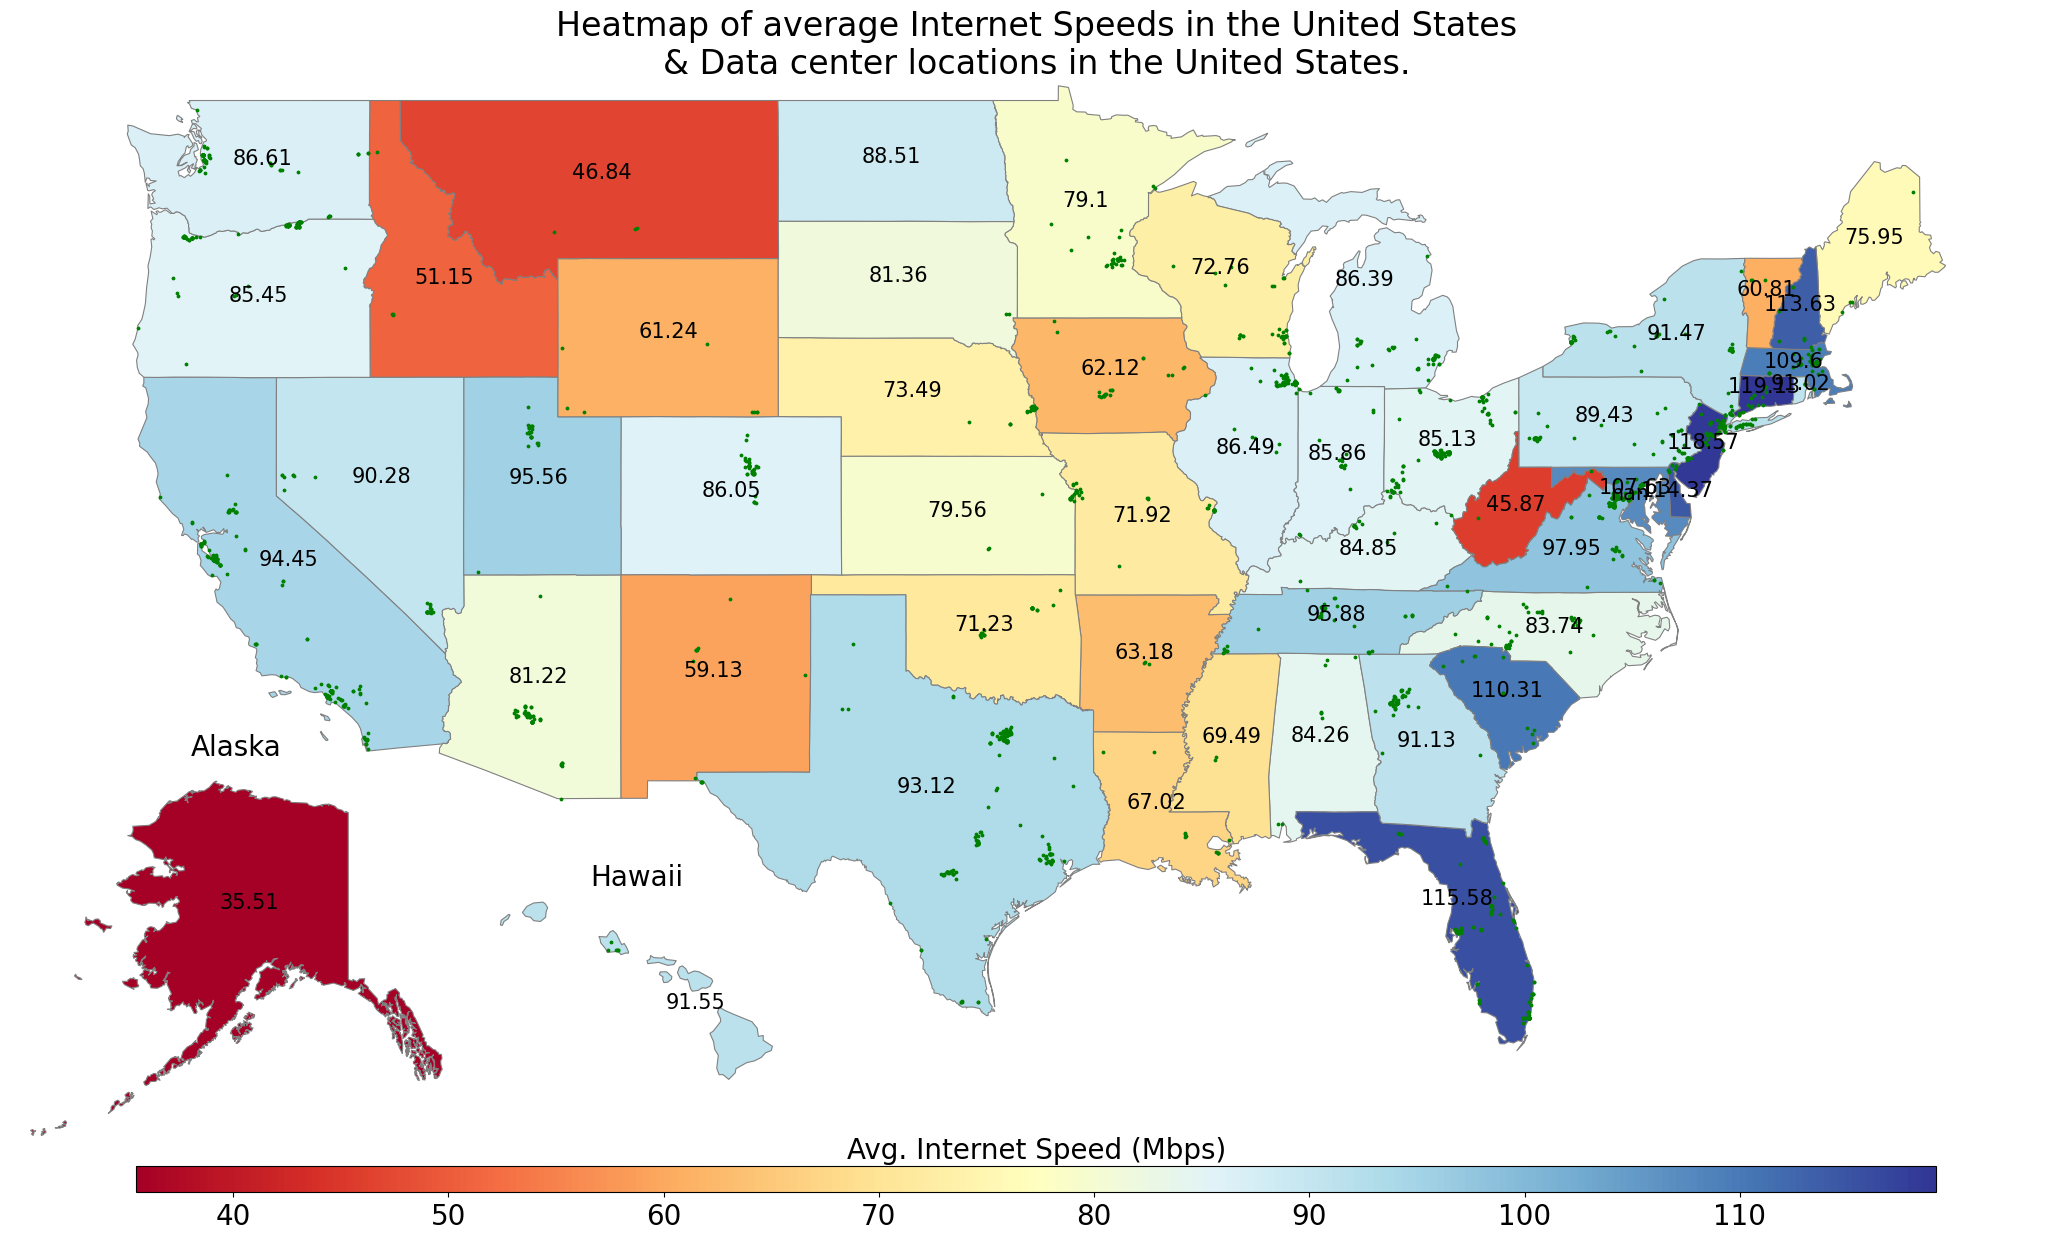

In [14]:
data_column = 'Internet Speed'

title = f'Heatmap of average Internet Speeds in the United States\n& Data center locations in the United States.'

plot_us_states(merged_data, data_column, 
               title=title, 
               colorbar_title='Avg. Internet Speed (Mbps)', 
               colormap='RdYlBu', 
               label_states=True,
               plot_points=dc_gdf, 
               point_color='green')

## State temperatures

First, we import the average annual temperature by states for 2023.

In [15]:
state_temp_file = os.path.join('..','in','state_temp.csv')
state_temp = pd.read_csv(state_temp_file, skiprows=4)
state_temp.head()

,ID,Name,Value,Anomaly (1901-2000 base period),Rank,1901-2000 Mean
0,1,Alabama,65.4,2.3,127,63.1
1,2,Arizona,60.8,1.4,105,59.4
2,3,Arkansas,62.9,2.5,126,60.4
3,4,California,58.2,0.8,92,57.4
4,5,Colorado,45.9,1.3,101,44.6


Then, we rename the "name" colum to "State_Name" and the "value" column to "temperature".

In [16]:
state_temp.rename(columns={'Name' : 'State_Name', 'Value' : 'temperature'}, inplace=True)

state_temp = state_temp[['State_Name','temperature']]

#converting to uppercase again, because thats what the merged_data shapefile uses for state names.
state_temp = uppercase_df(state_temp)

state_temp.head()

,State_Name,temperature
0,ALABAMA,65.4
1,ARIZONA,60.8
2,ARKANSAS,62.9
3,CALIFORNIA,58.2
4,COLORADO,45.9


Adding missing temperatures manually to each state

In [17]:
# Calculates the average of the annual high temperature and annual low temperature for Honolulu, Hawaii
avg_temp_hawaii = (84+71)/2

# Creates a data frame with the missing states and their average tempeatures 
missing_states = pd.DataFrame({
    'State_Name': ['ALASKA', 'DISTRICT OF COLUMBIA', 'HAWAII'],
    'temperature': [28.4, 61.2, avg_temp_hawaii]
})

state_temp = pd.concat([state_temp, missing_states])

state_temp

,State_Name,temperature
0,ALABAMA,65.4
1,ARIZONA,60.8
2,ARKANSAS,62.9
3,CALIFORNIA,58.2
4,COLORADO,45.9
5,CONNECTICUT,52.2
6,DELAWARE,57.9
7,FLORIDA,73.2
8,GEORGIA,65.6
9,IDAHO,43.9


Then we convert the temperatures from fahrenheit to celsius by applying a custom funtion to the column.

In [18]:
def fahrenheit_to_celsius(fahrenheit):
    """
    Convert Fahrenheit to Celsius.

    Parameters:
    fahrenheit (float): Temperature in Fahrenheit.

    Returns:
    float: Temperature in Celsius.
    """
    celsius = (fahrenheit - 32) * 5.0/9.0
    return celsius

state_temp['temperature'] = state_temp['temperature'].apply(fahrenheit_to_celsius)

state_temp.head()

,State_Name,temperature
0,ALABAMA,18.555556
1,ARIZONA,16.000000
2,ARKANSAS,17.166667
3,CALIFORNIA,14.555556
4,COLORADO,7.722222


In [19]:
merged_data = merged_data.merge(state_temp, how='left', on='State_Name')

merged_data.head()


,FID,Program,State_Code,State_Name,Flowing_St,FID_1,geometry,Datacenter_Count,Year,State,Industry Sector Category,Residential,Commercial,Industrial,Transportation,Other,Total,Internet Speed,temperature
0,1,PERMIT TRACKING,AL,ALABAMA,F,919,"POLYGON ((-85.07007 31.98070, -85.11515 31.907...",11.0,2020,AL,Total Electric Industry,12.58,11.55,5.87,0.00,NaN,9.84,84.26,18.555556
1,2,None,AK,ALASKA,N,920,"MULTIPOLYGON (((-161.33379 58.73325, -161.3824...",NaN,2020,AK,Total Electric Industry,22.57,19.58,15.88,0.00,NaN,19.82,35.51,-2.000000
2,3,AZURITE,AZ,ARIZONA,F,921,"POLYGON ((-114.52063 33.02771, -114.55909 33.0...",66.0,2020,AZ,Total Electric Industry,12.27,10.11,6.07,9.38,NaN,10.44,81.22,16.000000
3,4,PDS,AR,ARKANSAS,F,922,"POLYGON ((-94.46169 34.19677, -94.45262 34.508...",3.0,2020,AR,Total Electric Industry,10.41,8.61,5.89,13.32,NaN,8.32,63.18,17.166667
4,5,None,CA,CALIFORNIA,N,923,"MULTIPOLYGON (((-121.66522 38.16929, -121.7823...",259.0,2020,CA,Total Electric Industry,20.45,17.53,14.27,10.07,NaN,18.00,94.45,14.555556


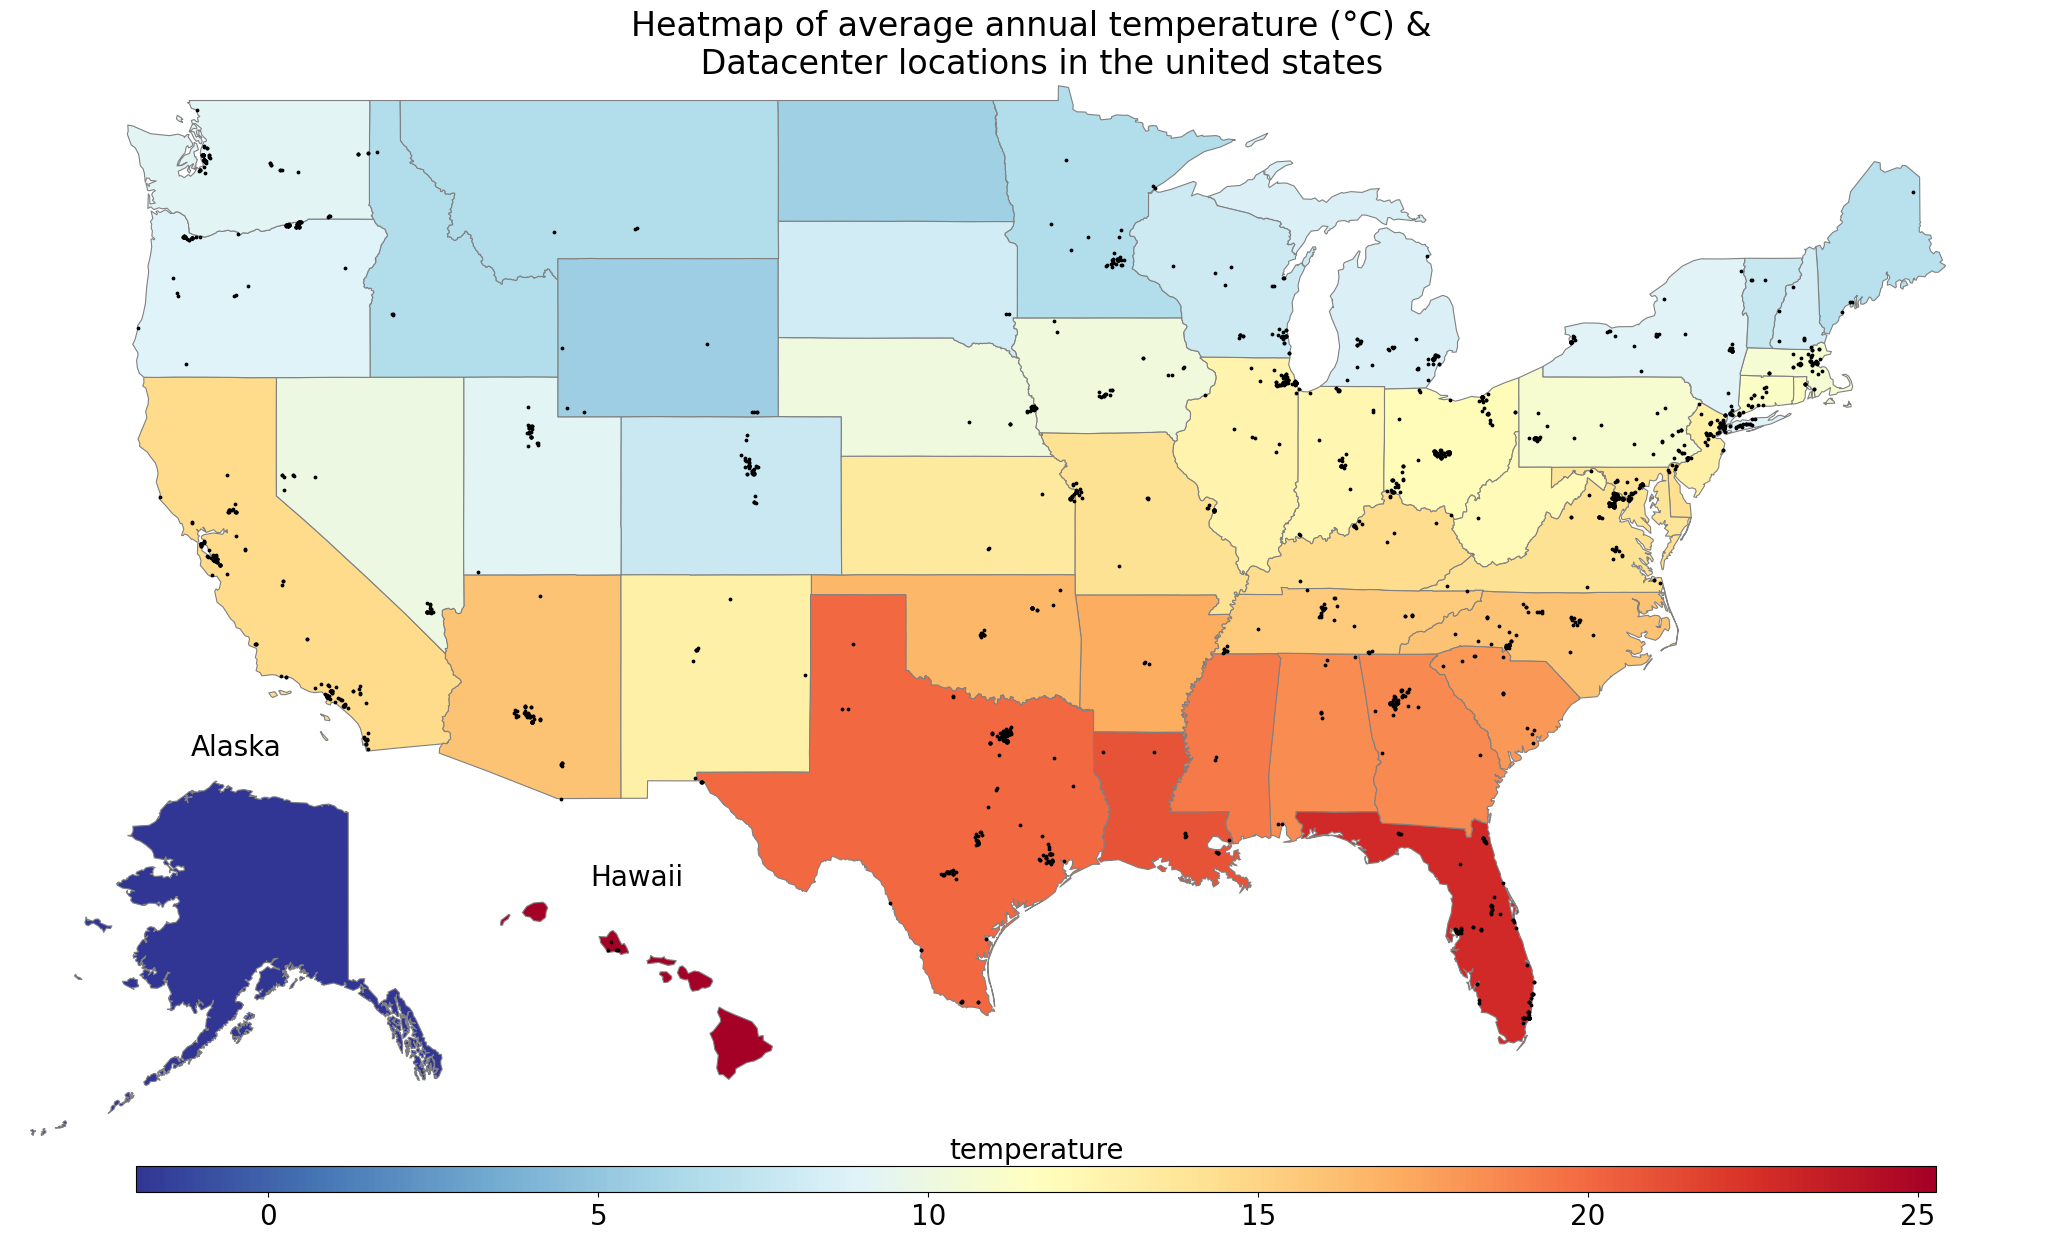

In [20]:
data_column = 'temperature'

title = f'Heatmap of average annual temperature (°C) & \n Datacenter locations in the united states'

plot_us_states(merged_data, data_column, plot_points=dc_gdf, title=title, colormap='RdYlBu_r')

## Humidity

In [21]:
humidity_file = os.path.join('..','in','most-humid-states-2024.csv')
state_humidity = pd.read_csv(humidity_file)
state_humidity.head()

,state,MostHumidStatesAverageRelativeHumidity,MostHumidStatesAverageDewPointF
0,Alabama,71.6,54.0
1,Alaska,77.1,26.5
2,Arizona,38.5,32.5
3,Arkansas,70.9,50.7
4,California,61.0,44.2


Renaming the columns

In [22]:
state_humidity.rename(columns={'state' : 'State_Name',
                               'MostHumidStatesAverageRelativeHumidity' : 'relative_humidity',
                               'MostHumidStatesAverageDewPointF' : 'avg_dewpoint'},
                               inplace=True)
state_humidity.head()

,State_Name,relative_humidity,avg_dewpoint
0,Alabama,71.6,54.0
1,Alaska,77.1,26.5
2,Arizona,38.5,32.5
3,Arkansas,70.9,50.7
4,California,61.0,44.2


Converting State_Name column to uppercase, and converting dewpoint from fahrenheit to celsius

In [23]:
state_humidity = uppercase_df(state_humidity)

state_humidity['avg_dewpoint'] = state_humidity['avg_dewpoint'].apply(fahrenheit_to_celsius)

state_humidity.head()

,State_Name,relative_humidity,avg_dewpoint
0,ALABAMA,71.6,12.222222
1,ALASKA,77.1,-3.055556
2,ARIZONA,38.5,0.277778
3,ARKANSAS,70.9,10.388889
4,CALIFORNIA,61.0,6.777778


In [24]:
merged_data = merged_data.merge(state_humidity, how='left', on='State_Name')

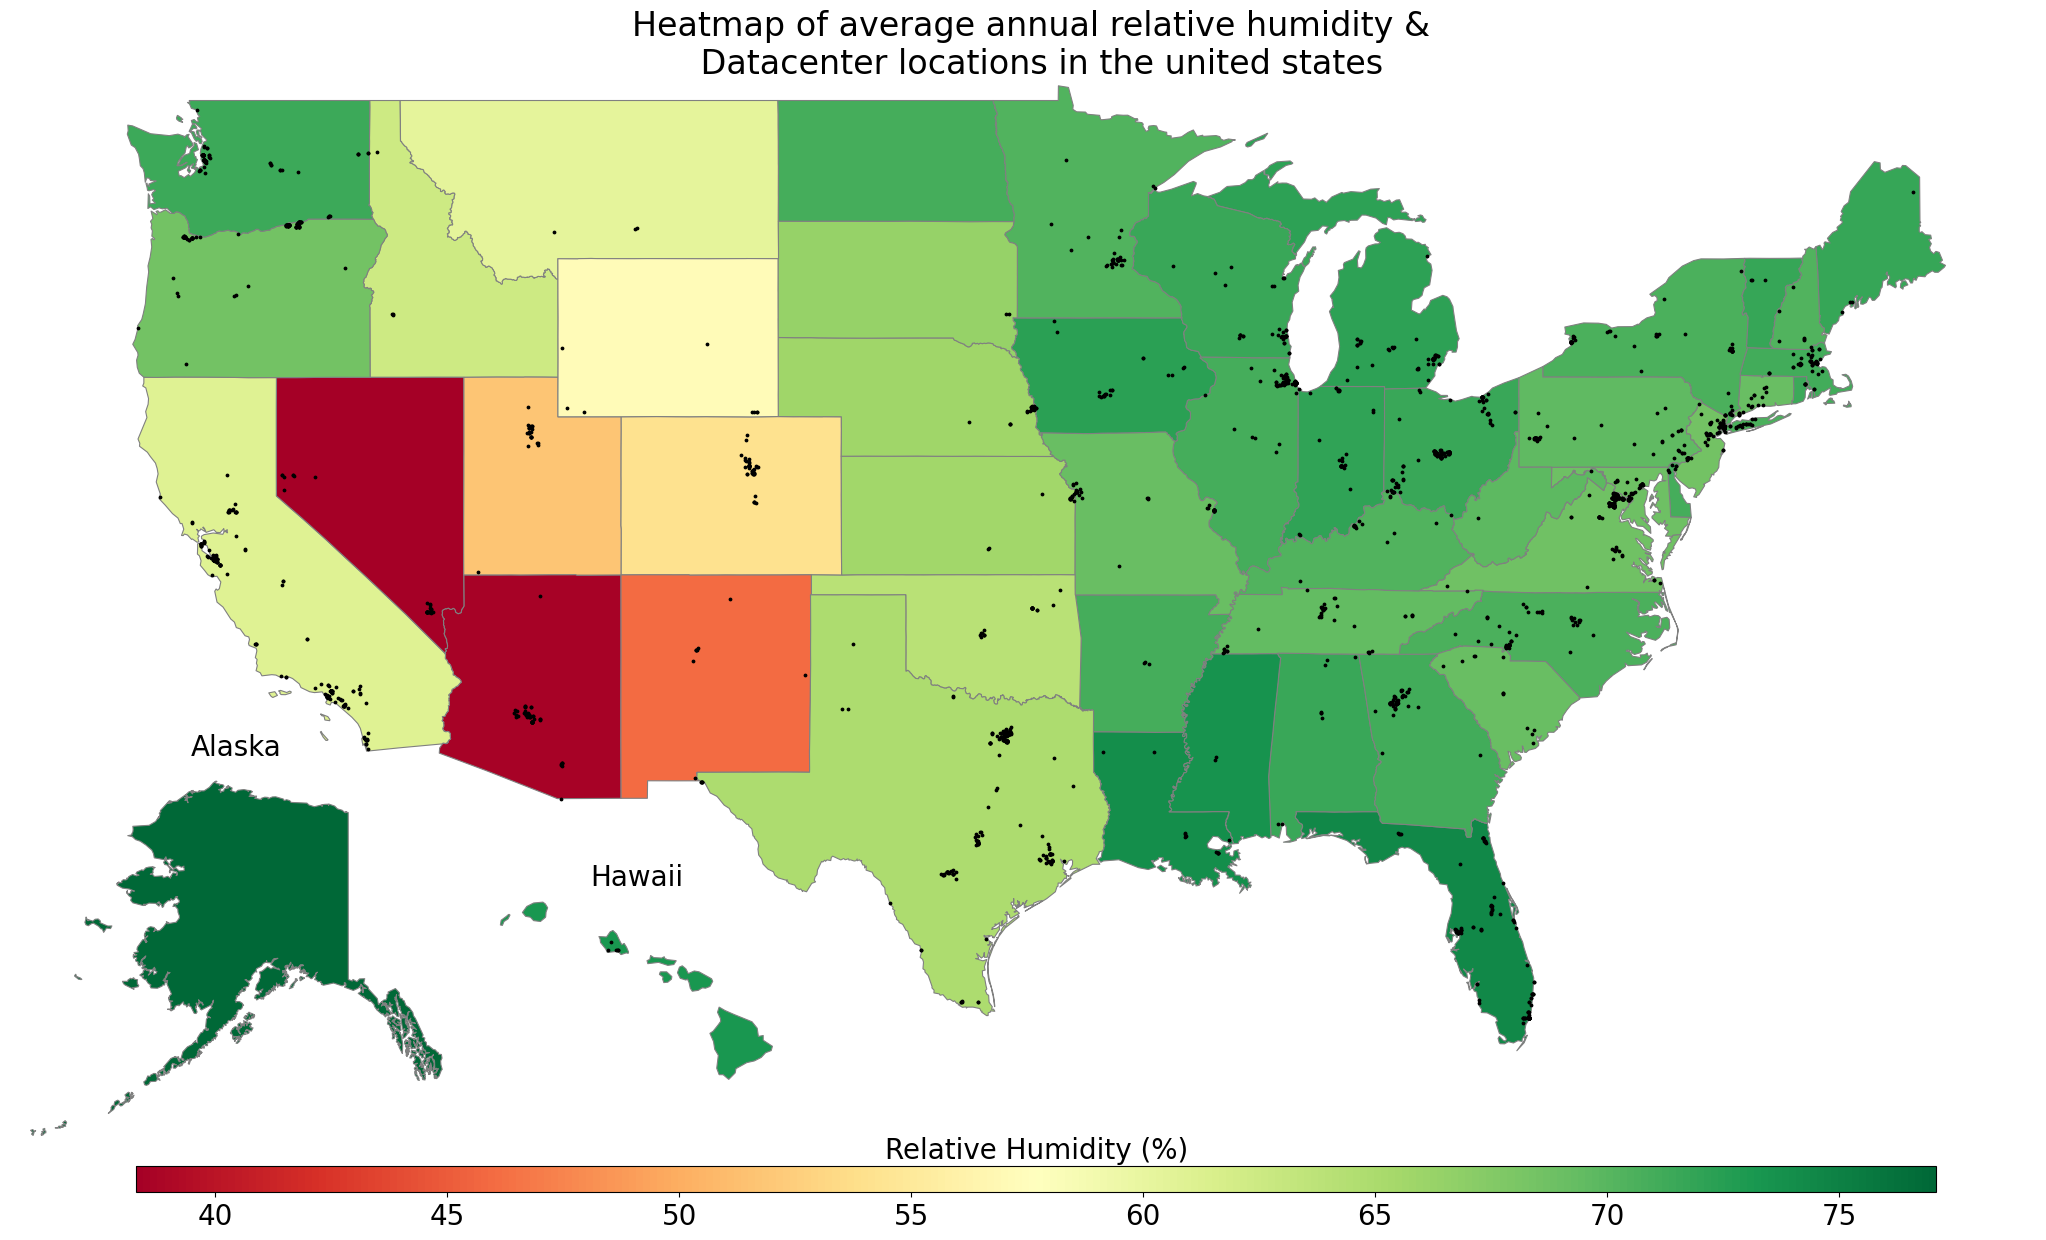

In [25]:
data_column = 'relative_humidity'

title = f'Heatmap of average annual relative humidity & \n Datacenter locations in the united states'

plot_us_states(merged_data, data_column, 
               plot_points=dc_gdf, 
               title=title, 
               label_states=False,
               colorbar_title='Relative Humidity (%)',
               colormap='RdYlGn')

# Population density

In [26]:
pop_density_file = os.path.join('..','in','united-states-by-density-2024.csv')
pop_density = pd.read_csv(pop_density_file)
pop_density.head()

,state,densityMi,population,TotalArea
0,Alabama,101.55066,5143033.0,52420.0
1,Alaska,1.28546,733536.0,665384.0
2,Arizona,65.99824,7497004.0,113990.0
3,Arkansas,59.36504,3089060.0,53179.0
4,California,249.64706,38889770.0,163696.0


In [27]:
pop_density.rename(columns={'state' : 'State_Name'},
                            inplace=True)
pop_density = uppercase_df(pop_density)
pop_density.head()

,State_Name,densityMi,population,TotalArea
0,ALABAMA,101.55066,5143033.0,52420.0
1,ALASKA,1.28546,733536.0,665384.0
2,ARIZONA,65.99824,7497004.0,113990.0
3,ARKANSAS,59.36504,3089060.0,53179.0
4,CALIFORNIA,249.64706,38889770.0,163696.0


In [28]:
merged_data = merged_data.merge(pop_density, how='left', on='State_Name')

In [29]:
merged_data.head()

,FID,Program,State_Code,State_Name,Flowing_St,FID_1,geometry,Datacenter_Count,Year,State,...,Transportation,Other,Total,Internet Speed,temperature,relative_humidity,avg_dewpoint,densityMi,population,TotalArea
0,1,PERMIT TRACKING,AL,ALABAMA,F,919,"POLYGON ((-85.07007 31.98070, -85.11515 31.907...",11.0,2020,AL,...,0.00,NaN,9.84,84.26,18.555556,71.6,12.222222,101.55066,5143033.0,52420.0
1,2,None,AK,ALASKA,N,920,"MULTIPOLYGON (((-161.33379 58.73325, -161.3824...",NaN,2020,AK,...,0.00,NaN,19.82,35.51,-2.000000,77.1,-3.055556,1.28546,733536.0,665384.0
2,3,AZURITE,AZ,ARIZONA,F,921,"POLYGON ((-114.52063 33.02771, -114.55909 33.0...",66.0,2020,AZ,...,9.38,NaN,10.44,81.22,16.000000,38.5,0.277778,65.99824,7497004.0,113990.0
3,4,PDS,AR,ARKANSAS,F,922,"POLYGON ((-94.46169 34.19677, -94.45262 34.508...",3.0,2020,AR,...,13.32,NaN,8.32,63.18,17.166667,70.9,10.388889,59.36504,3089060.0,53179.0
4,5,None,CA,CALIFORNIA,N,923,"MULTIPOLYGON (((-121.66522 38.16929, -121.7823...",259.0,2020,CA,...,10.07,NaN,18.00,94.45,14.555556,61.0,6.777778,249.64706,38889770.0,163696.0


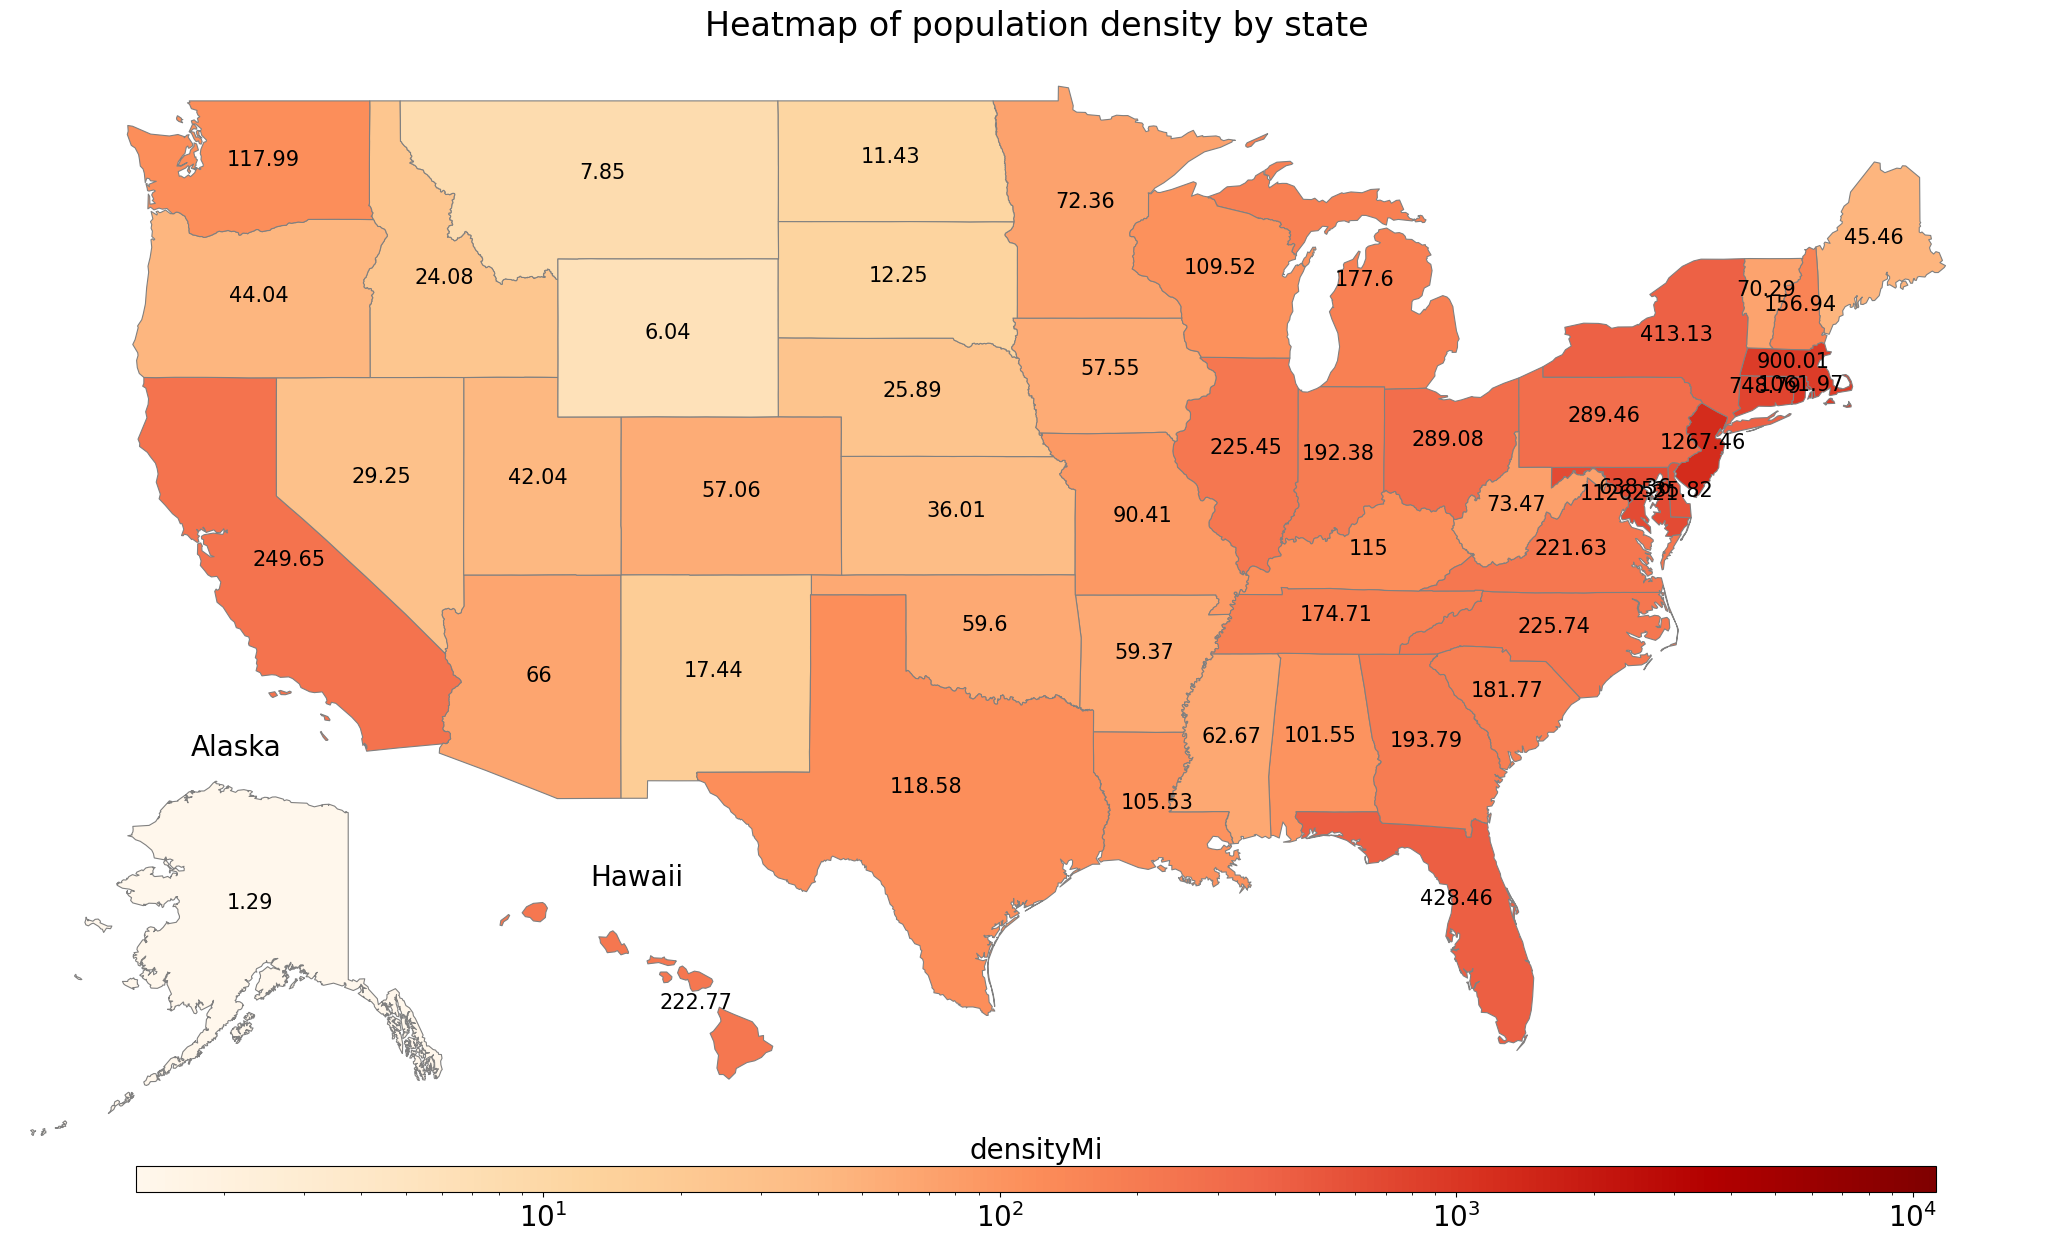

In [30]:
data_column = 'densityMi'

title = f'Heatmap of population density by state'

plot_us_states(merged_data,
               data_column,
               title=title,
               colormap='OrRd',
               label_states=True,
               log_scale=True)

# Renewable energy by state

In [31]:
green_states_file = os.path.join('..','in','green_states.csv')
green_states = pd.read_csv(green_states_file)
green_states.head()

,State,Renewable,Renewable rank,% Coal,% Gas,% Nuclear,% Hydro,% Wind,% Solar
0,South Dakota,83%,1,9%,7%,0%,29%,54%,0%
1,Vermont,76%,2,0%,0%,0%,52%,16%,8%
2,Washington,74%,3,3%,15%,8%,66%,9%,0%
3,Idaho,69%,4,0%,29%,0%,49%,17%,3%
4,Oregon,64%,5,0%,35%,0%,46%,16%,2%


In [32]:
green_states.rename(columns={'State' : 'State_Name'},
                            inplace=True)
green_states = uppercase_df(green_states)
green_states = remove_trailing_space_df(green_states)
green_states=green_states[['State_Name','Renewable']]
green_states.head()

,State_Name,Renewable
0,SOUTH DAKOTA,83%
1,VERMONT,76%
2,WASHINGTON,74%
3,IDAHO,69%
4,OREGON,64%


In [33]:
green_states

,State_Name,Renewable
0,SOUTH DAKOTA,83%
1,VERMONT,76%
2,WASHINGTON,74%
3,IDAHO,69%
4,OREGON,64%
5,IOWA,59%
6,MAINE,56%
7,MONTANA,51%
8,KANSAS,46%
9,OKLAHOMA,44%


In [34]:
green_states['Renewable'] = green_states['Renewable'].str.rstrip('%').astype(float)

In [35]:
merged_data = merged_data.merge(green_states, how='left', on='State_Name')

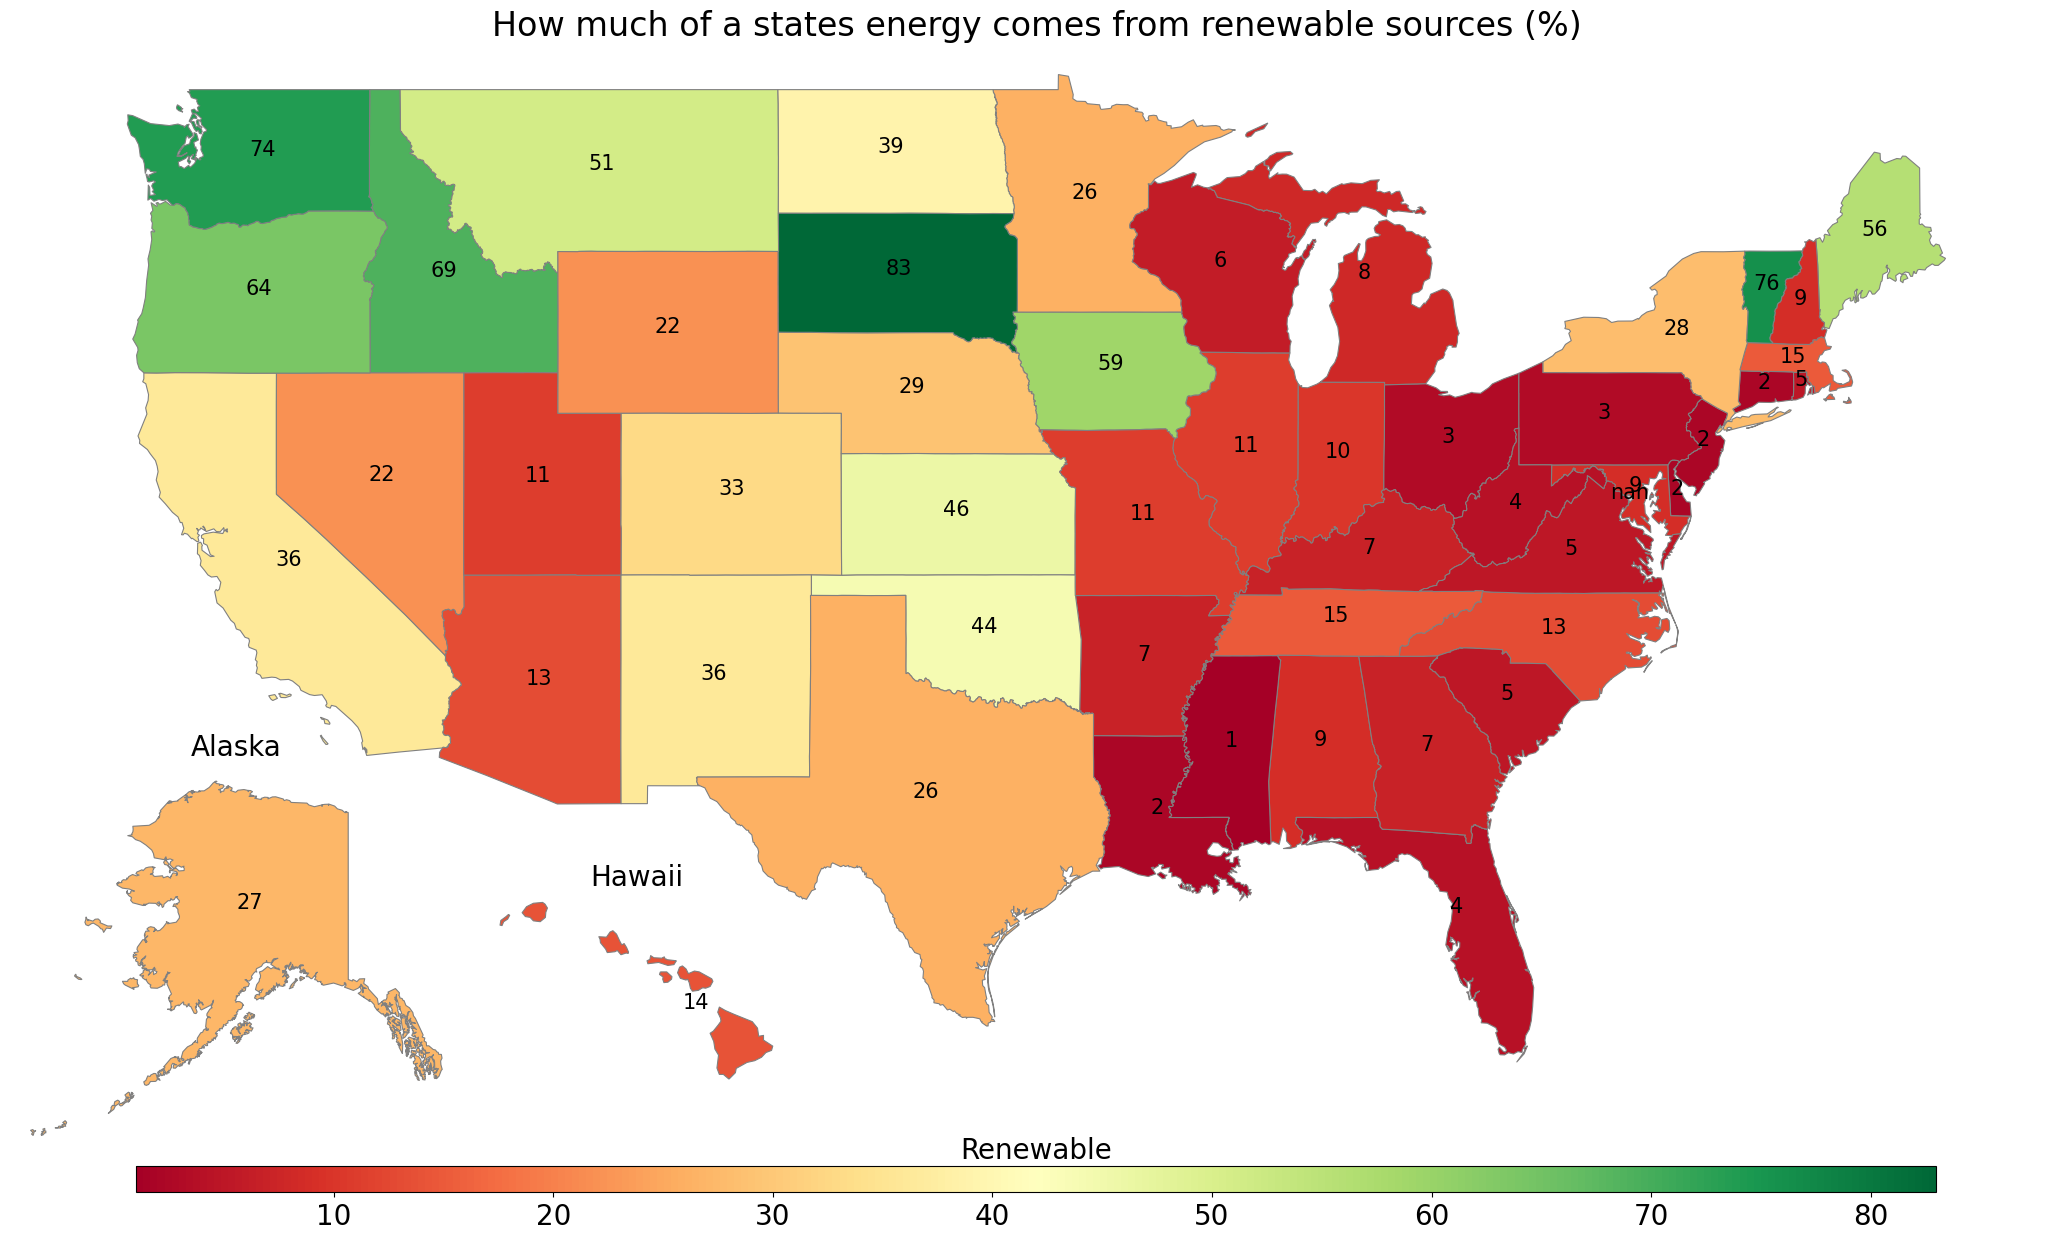

In [36]:
data_column = 'Renewable'

title = f'How much of a states energy comes from renewable sources (%)'

plot_us_states(merged_data,
               data_column,
               title=title,
               colormap='RdYlGn',
               label_states=True)

In [37]:
merged_data

,FID,Program,State_Code,State_Name,Flowing_St,FID_1,geometry,Datacenter_Count,Year,State,...,Other,Total,Internet Speed,temperature,relative_humidity,avg_dewpoint,densityMi,population,TotalArea,Renewable
0,1,PERMIT TRACKING,AL,ALABAMA,F,919,"POLYGON ((-85.07007 31.98070, -85.11515 31.907...",11.0,2020,AL,...,NaN,9.84,84.26,18.555556,71.6,12.222222,101.55066,5143033.0,52420.0,9.0
1,2,None,AK,ALASKA,N,920,"MULTIPOLYGON (((-161.33379 58.73325, -161.3824...",NaN,2020,AK,...,NaN,19.82,35.51,-2.000000,77.1,-3.055556,1.28546,733536.0,665384.0,27.0
2,3,AZURITE,AZ,ARIZONA,F,921,"POLYGON ((-114.52063 33.02771, -114.55909 33.0...",66.0,2020,AZ,...,NaN,10.44,81.22,16.000000,38.5,0.277778,65.99824,7497004.0,113990.0,13.0
3,4,PDS,AR,ARKANSAS,F,922,"POLYGON ((-94.46169 34.19677, -94.45262 34.508...",3.0,2020,AR,...,NaN,8.32,63.18,17.166667,70.9,10.388889,59.36504,3089060.0,53179.0,7.0
4,5,None,CA,CALIFORNIA,N,923,"MULTIPOLYGON (((-121.66522 38.16929, -121.7823...",259.0,2020,CA,...,NaN,18.00,94.45,14.555556,61.0,6.777778,249.64706,38889770.0,163696.0,36.0
5,6,ECOMAP,CO,COLORADO,F,924,"POLYGON ((-102.04446 37.64147, -102.04201 37.3...",52.0,2020,CO,...,NaN,10.27,86.05,7.722222,54.1,-1.777778,57.06356,5914181.0,104094.0,33.0
6,7,SIMS,CT,CONNECTICUT,F,925,"POLYGON ((-73.53039 41.52275, -73.51715 41.665...",18.0,2020,CT,...,NaN,19.13,119.13,11.222222,69.2,4.833333,748.79100,3625646.0,5543.0,2.0
7,8,None,DE,DELAWARE,P,926,"POLYGON ((-75.70707 38.55759, -75.71071 38.649...",5.0,2020,DE,...,NaN,10.24,114.37,14.388889,70.9,7.666667,535.82401,1044321.0,2489.0,2.0
8,9,None,DC,DISTRICT OF COLUMBIA,P,927,"POLYGON ((-77.00793 38.96667, -76.91090 38.890...",15.0,2020,DC,...,NaN,11.90,NaN,16.222222,NaN,NaN,11262.21311,686995.0,NaN,NaN
9,10,None,FL,FLORIDA,P,928,"MULTIPOLYGON (((-80.78566 28.78519, -80.76242 ...",119.0,2020,FL,...,NaN,10.06,115.58,22.888889,74.5,17.055556,428.45559,22975931.0,65758.0,4.0
